# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

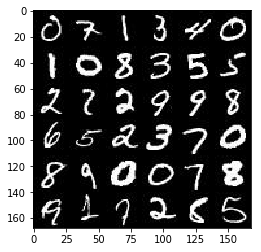

In [2]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

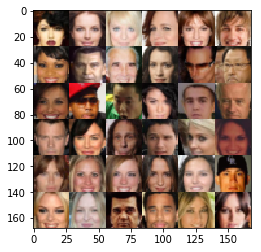

In [3]:
show_n_images = 36

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Real input images placeholder
    inputs_images = tf.placeholder( tf.float32, (None, image_width, image_height, image_channels), name = 'input_images')
    # Z input placeholder
    inputs_z = tf.placeholder( tf.float32, (None, z_dim), name = 'input_z' )
    # Learning rate placeholder
    learning_rate = tf.placeholder( tf.float32, name = 'learning_rate' )
    
    return inputs_images, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha=0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d( images, 64, 5, strides=2, padding='same' )
        relu1 = tf.maximum( alpha * x1, x1 )
        # 16x16x64
        
        x2 = tf.layers.conv2d( relu1, 128, 5, strides=2, padding='same' )
        bn2 = tf.layers.batch_normalization( x2, training = True )
        relu2 = tf.maximum( alpha * bn2, bn2 )
        # 8x8x128
        
        x3 = tf.layers.conv2d( relu2, 256, 5, strides=2, padding='same' )
        bn3 = tf.layers.batch_normalization( x3, training = True )
        relu3 = tf.maximum( alpha * bn3, bn3 )
        # 4x4x256

        # Flatten it
        flat = tf.reshape( relu3, (-1, 4 * 4 * 256) )
        logits = tf.layers.dense( flat, 1 )
        out = tf.sigmoid( logits )

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse = not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7 * 7 * 512)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape( x1, (-1, 7, 7, 512) )
        x1 = tf.layers.batch_normalization( x1, training = is_train )
        x1 = tf.maximum( alpha * x1, x1 )
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose( x1, 256, 5, strides = 2, padding = 'same' )
        x2 = tf.layers.batch_normalization( x2, training = is_train )
        x2 = tf.maximum( alpha * x2, x2 )
        x2 = tf.nn.dropout(x2, keep_prob = keep_prob)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose( x2, 128, 5, strides = 2, padding = 'same' )
        x3 = tf.layers.batch_normalization( x3, training=is_train )
        x3 = tf.maximum( alpha * x3, x3 )
        x3 = tf.nn.dropout(x3, keep_prob = keep_prob)
        # 28x28x128 now
        
        x4 = tf.layers.conv2d_transpose( x2, 64, 5, strides = 1, padding = 'same' )
        x4 = tf.layers.batch_normalization( x3, training=is_train )
        x4 = tf.maximum( alpha * x4, x4 )
        x4 = tf.nn.dropout(x4, keep_prob = keep_prob)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose (x3, out_channel_dim, 3, strides=1, padding='same' )
        # 28x28x5 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # generator model
    g_model = generator( input_z, out_channel_dim )
    
    # discriminator model
    d_model_real, d_logits_real = discriminator( input_real )
    d_model_fake, d_logits_fake = discriminator( g_model, reuse = True )
    
    # generator loss
    g_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( logits = d_logits_fake, 
                                                                      labels = tf.ones_like(d_model_fake) ) )
    # discriminator loss
    # Using smoother label technique to improve performance. 
    d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( logits = d_logits_real, 
                                                                           labels = tf.ones_like(d_model_real)*0.9 ) )    
    
    d_loss_fake = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits( logits = d_logits_fake, 
                                                                           labels=tf.zeros_like(d_model_fake) ) )
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables( )
    d_vars = [ var for var in t_vars if var.name.startswith('discriminator') ]
    g_vars = [ var for var in t_vars if var.name.startswith('generator') ]

    # Optimize
    with tf.control_dependencies( tf.get_collection(tf.GraphKeys.UPDATE_OPS) ):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 10
    show_every = 100
    
    # Building Model
    _, image_width, image_height, image_channels = data_shape
    
    input_images, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    discriminator_loss, genator_loss = model_loss(input_images, input_z, image_channels)
    discriminator_opt,  genator_opt  = model_opt(discriminator_loss, genator_loss, lr, beta1)
    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # Trainning Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform( -1, 1, size = (batch_size, z_dim) )

                # Run optimizers
                _ = sess.run( discriminator_opt, 
                              feed_dict = { input_images: batch_images, input_z: batch_z, lr: learning_rate } )
                _ = sess.run( genator_opt,  
                              feed_dict = { input_images: batch_images, input_z: batch_z, lr: learning_rate } )

                # Print the initial output
                if steps == 1:
                    print( "Initial output: ")
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                
                
                # Print the losses at the end of each epoch
                if steps % 10 == 0:
                    train_loss_d = discriminator_loss.eval( {input_z: batch_z, input_images: batch_images} )
                    train_loss_g = genator_loss.eval( {input_z: batch_z} )
         
                    print( "Epoch {}/{}...".format( epoch_i + 1, epochs ),
                           "Generator Loss: {:.4f}".format( train_loss_g ),
                           "Discriminator Loss: {:.4f}...".format( train_loss_d ) )
                    
                    # Save losses to view after training
                    losses.append( (train_loss_d, train_loss_g) )

                if steps % 100 == 0:
                    show_generator_output( sess, 16, input_z, image_channels, data_image_mode )
                    
        saver.save(sess, './generator.ckpt')
    
    return losses

print("Train ok")

Train ok


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Initial output: 


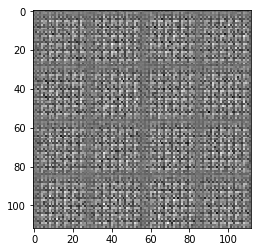

Epoch 1/2... Generator Loss: 3.2754 Discriminator Loss: 0.4091...
Epoch 1/2... Generator Loss: 4.4532 Discriminator Loss: 0.3504...
Epoch 1/2... Generator Loss: 5.1356 Discriminator Loss: 0.3536...
Epoch 1/2... Generator Loss: 1.4008 Discriminator Loss: 0.6929...
Epoch 1/2... Generator Loss: 6.4583 Discriminator Loss: 0.4099...
Epoch 1/2... Generator Loss: 4.9566 Discriminator Loss: 0.3705...
Epoch 1/2... Generator Loss: 4.9012 Discriminator Loss: 0.3570...
Epoch 1/2... Generator Loss: 7.6279 Discriminator Loss: 0.5448...
Epoch 1/2... Generator Loss: 1.0546 Discriminator Loss: 1.3053...
Epoch 1/2... Generator Loss: 0.8018 Discriminator Loss: 1.1640...


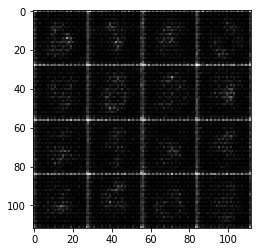

Epoch 1/2... Generator Loss: 1.3300 Discriminator Loss: 0.9156...
Epoch 1/2... Generator Loss: 3.5619 Discriminator Loss: 1.4158...
Epoch 1/2... Generator Loss: 2.0970 Discriminator Loss: 0.6804...
Epoch 1/2... Generator Loss: 3.7097 Discriminator Loss: 0.9088...
Epoch 1/2... Generator Loss: 2.2875 Discriminator Loss: 0.5476...
Epoch 1/2... Generator Loss: 1.8691 Discriminator Loss: 0.5604...
Epoch 1/2... Generator Loss: 3.0492 Discriminator Loss: 0.4261...
Epoch 1/2... Generator Loss: 3.2458 Discriminator Loss: 0.4134...
Epoch 1/2... Generator Loss: 3.6950 Discriminator Loss: 0.3724...
Epoch 1/2... Generator Loss: 3.6718 Discriminator Loss: 0.3781...


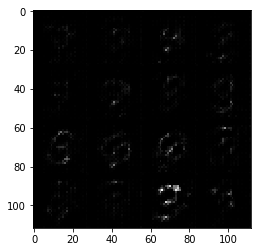

Epoch 1/2... Generator Loss: 3.2736 Discriminator Loss: 0.3935...
Epoch 1/2... Generator Loss: 4.2093 Discriminator Loss: 0.3601...
Epoch 1/2... Generator Loss: 4.8388 Discriminator Loss: 0.3576...
Epoch 1/2... Generator Loss: 3.9597 Discriminator Loss: 0.3570...
Epoch 1/2... Generator Loss: 3.7192 Discriminator Loss: 0.3690...
Epoch 1/2... Generator Loss: 5.2327 Discriminator Loss: 0.3507...
Epoch 1/2... Generator Loss: 5.1255 Discriminator Loss: 0.3469...
Epoch 1/2... Generator Loss: 2.2267 Discriminator Loss: 0.6368...
Epoch 1/2... Generator Loss: 4.9190 Discriminator Loss: 0.3464...
Epoch 1/2... Generator Loss: 4.7923 Discriminator Loss: 0.3568...


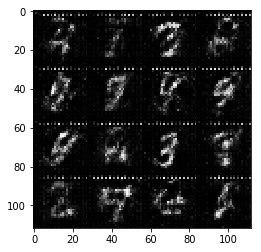

Epoch 1/2... Generator Loss: 5.0479 Discriminator Loss: 0.3448...
Epoch 1/2... Generator Loss: 5.3614 Discriminator Loss: 0.3450...
Epoch 1/2... Generator Loss: 3.4898 Discriminator Loss: 0.4017...
Epoch 1/2... Generator Loss: 4.4474 Discriminator Loss: 0.3614...
Epoch 1/2... Generator Loss: 4.2942 Discriminator Loss: 0.3798...
Epoch 1/2... Generator Loss: 9.8235 Discriminator Loss: 1.0906...
Epoch 1/2... Generator Loss: 4.6519 Discriminator Loss: 0.3645...
Epoch 1/2... Generator Loss: 3.9133 Discriminator Loss: 0.3646...
Epoch 1/2... Generator Loss: 5.0608 Discriminator Loss: 0.3509...
Epoch 1/2... Generator Loss: 4.6241 Discriminator Loss: 0.3494...


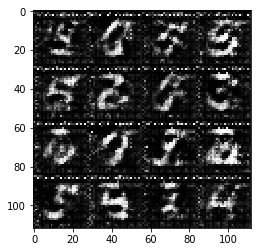

Epoch 1/2... Generator Loss: 4.5123 Discriminator Loss: 0.3523...
Epoch 1/2... Generator Loss: 5.4152 Discriminator Loss: 0.3394...
Epoch 1/2... Generator Loss: 5.2058 Discriminator Loss: 0.3417...
Epoch 1/2... Generator Loss: 5.5585 Discriminator Loss: 0.3378...
Epoch 1/2... Generator Loss: 4.9765 Discriminator Loss: 0.3410...
Epoch 1/2... Generator Loss: 5.1501 Discriminator Loss: 0.3439...
Epoch 2/2... Generator Loss: 5.4924 Discriminator Loss: 0.3452...
Epoch 2/2... Generator Loss: 4.4128 Discriminator Loss: 0.3458...
Epoch 2/2... Generator Loss: 6.1628 Discriminator Loss: 0.3376...
Epoch 2/2... Generator Loss: 4.7513 Discriminator Loss: 0.3481...


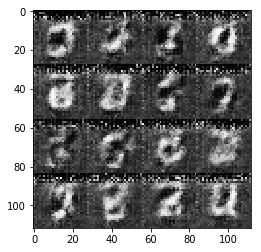

Epoch 2/2... Generator Loss: 1.0505 Discriminator Loss: 1.0717...
Epoch 2/2... Generator Loss: 3.9557 Discriminator Loss: 0.5578...
Epoch 2/2... Generator Loss: 4.3386 Discriminator Loss: 0.3681...
Epoch 2/2... Generator Loss: 1.6992 Discriminator Loss: 0.8358...
Epoch 2/2... Generator Loss: 2.5630 Discriminator Loss: 0.4838...
Epoch 2/2... Generator Loss: 2.8694 Discriminator Loss: 0.4594...
Epoch 2/2... Generator Loss: 2.2556 Discriminator Loss: 0.5939...
Epoch 2/2... Generator Loss: 4.1630 Discriminator Loss: 0.3897...
Epoch 2/2... Generator Loss: 3.9294 Discriminator Loss: 0.3984...
Epoch 2/2... Generator Loss: 3.1827 Discriminator Loss: 0.4125...


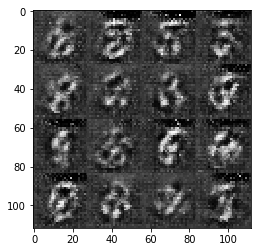

Epoch 2/2... Generator Loss: 5.4527 Discriminator Loss: 0.5337...
Epoch 2/2... Generator Loss: 4.2431 Discriminator Loss: 0.4383...
Epoch 2/2... Generator Loss: 3.3476 Discriminator Loss: 0.4386...
Epoch 2/2... Generator Loss: 3.6527 Discriminator Loss: 0.4169...
Epoch 2/2... Generator Loss: 3.2298 Discriminator Loss: 0.3959...
Epoch 2/2... Generator Loss: 3.8514 Discriminator Loss: 0.4401...
Epoch 2/2... Generator Loss: 4.8329 Discriminator Loss: 0.3533...
Epoch 2/2... Generator Loss: 3.2489 Discriminator Loss: 0.3975...
Epoch 2/2... Generator Loss: 3.5557 Discriminator Loss: 0.3820...
Epoch 2/2... Generator Loss: 4.9559 Discriminator Loss: 0.7225...


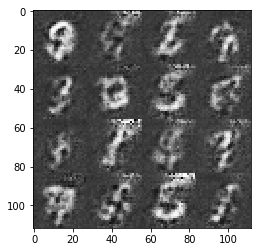

Epoch 2/2... Generator Loss: 3.3074 Discriminator Loss: 0.4100...
Epoch 2/2... Generator Loss: 4.4047 Discriminator Loss: 0.3621...
Epoch 2/2... Generator Loss: 4.8769 Discriminator Loss: 0.3521...
Epoch 2/2... Generator Loss: 3.8937 Discriminator Loss: 0.3838...
Epoch 2/2... Generator Loss: 4.8624 Discriminator Loss: 0.3534...
Epoch 2/2... Generator Loss: 4.0310 Discriminator Loss: 0.3994...
Epoch 2/2... Generator Loss: 3.6439 Discriminator Loss: 0.3803...
Epoch 2/2... Generator Loss: 3.0989 Discriminator Loss: 0.4502...
Epoch 2/2... Generator Loss: 3.9574 Discriminator Loss: 0.3812...
Epoch 2/2... Generator Loss: 4.0271 Discriminator Loss: 0.3851...


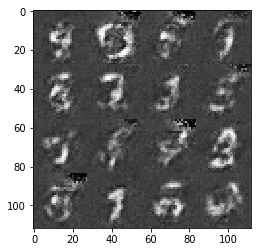

Epoch 2/2... Generator Loss: 3.0254 Discriminator Loss: 0.4069...
Epoch 2/2... Generator Loss: 4.5447 Discriminator Loss: 0.3526...
Epoch 2/2... Generator Loss: 3.9983 Discriminator Loss: 0.4040...
Epoch 2/2... Generator Loss: 3.1563 Discriminator Loss: 0.4106...
Epoch 2/2... Generator Loss: 3.4287 Discriminator Loss: 0.4749...
Epoch 2/2... Generator Loss: 2.7254 Discriminator Loss: 0.4168...
Epoch 2/2... Generator Loss: 3.1605 Discriminator Loss: 0.4069...
Epoch 2/2... Generator Loss: 2.8856 Discriminator Loss: 0.4334...
Epoch 2/2... Generator Loss: 3.0747 Discriminator Loss: 0.4178...
Epoch 2/2... Generator Loss: 2.7393 Discriminator Loss: 0.8871...


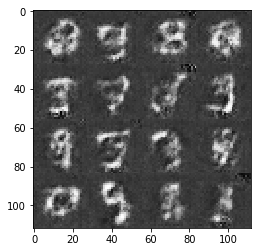

Epoch 2/2... Generator Loss: 2.0216 Discriminator Loss: 0.5281...
Epoch 2/2... Generator Loss: 3.4675 Discriminator Loss: 0.4482...
Epoch 2/2... Generator Loss: 3.5932 Discriminator Loss: 0.4092...


In [25]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Initial output: 


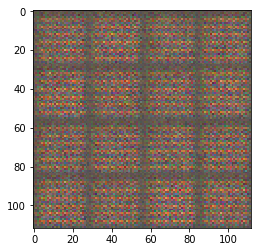

Epoch 1/1... Generator Loss: 2.5892 Discriminator Loss: 0.6074...
Epoch 1/1... Generator Loss: 2.9537 Discriminator Loss: 0.4542...
Epoch 1/1... Generator Loss: 2.5388 Discriminator Loss: 0.5341...
Epoch 1/1... Generator Loss: 0.8107 Discriminator Loss: 1.1896...
Epoch 1/1... Generator Loss: 1.4123 Discriminator Loss: 0.9181...
Epoch 1/1... Generator Loss: 3.6875 Discriminator Loss: 0.5711...
Epoch 1/1... Generator Loss: 3.3832 Discriminator Loss: 0.4470...
Epoch 1/1... Generator Loss: 2.9509 Discriminator Loss: 0.4693...
Epoch 1/1... Generator Loss: 1.9137 Discriminator Loss: 0.6419...
Epoch 1/1... Generator Loss: 3.2242 Discriminator Loss: 0.4460...


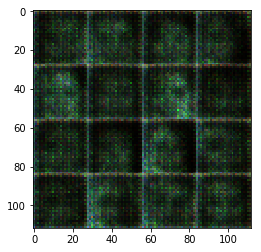

Epoch 1/1... Generator Loss: 2.7536 Discriminator Loss: 0.4621...
Epoch 1/1... Generator Loss: 4.4962 Discriminator Loss: 0.3581...
Epoch 1/1... Generator Loss: 3.3022 Discriminator Loss: 0.4037...
Epoch 1/1... Generator Loss: 1.6185 Discriminator Loss: 0.7019...
Epoch 1/1... Generator Loss: 4.0220 Discriminator Loss: 0.3826...
Epoch 1/1... Generator Loss: 2.0833 Discriminator Loss: 0.5272...
Epoch 1/1... Generator Loss: 3.8975 Discriminator Loss: 0.3669...
Epoch 1/1... Generator Loss: 3.5487 Discriminator Loss: 0.4015...
Epoch 1/1... Generator Loss: 0.7530 Discriminator Loss: 1.3348...
Epoch 1/1... Generator Loss: 3.2099 Discriminator Loss: 0.4501...


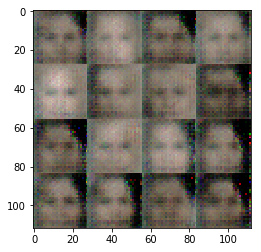

Epoch 1/1... Generator Loss: 3.1804 Discriminator Loss: 0.4440...
Epoch 1/1... Generator Loss: 2.8167 Discriminator Loss: 0.4513...
Epoch 1/1... Generator Loss: 4.4480 Discriminator Loss: 0.4195...
Epoch 1/1... Generator Loss: 3.1842 Discriminator Loss: 0.4525...
Epoch 1/1... Generator Loss: 3.4499 Discriminator Loss: 0.4131...
Epoch 1/1... Generator Loss: 3.5591 Discriminator Loss: 0.4092...
Epoch 1/1... Generator Loss: 1.8943 Discriminator Loss: 0.6961...
Epoch 1/1... Generator Loss: 0.7350 Discriminator Loss: 1.2133...
Epoch 1/1... Generator Loss: 2.5709 Discriminator Loss: 0.4877...
Epoch 1/1... Generator Loss: 3.2443 Discriminator Loss: 0.4075...


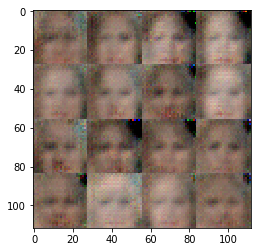

Epoch 1/1... Generator Loss: 3.3872 Discriminator Loss: 0.4217...
Epoch 1/1... Generator Loss: 2.3737 Discriminator Loss: 0.5542...
Epoch 1/1... Generator Loss: 2.0418 Discriminator Loss: 1.0250...
Epoch 1/1... Generator Loss: 1.9172 Discriminator Loss: 0.6978...
Epoch 1/1... Generator Loss: 2.3054 Discriminator Loss: 0.5554...
Epoch 1/1... Generator Loss: 3.6670 Discriminator Loss: 0.4026...
Epoch 1/1... Generator Loss: 3.4243 Discriminator Loss: 0.4056...
Epoch 1/1... Generator Loss: 2.8409 Discriminator Loss: 0.4284...
Epoch 1/1... Generator Loss: 4.7745 Discriminator Loss: 0.3635...
Epoch 1/1... Generator Loss: 3.8168 Discriminator Loss: 0.3781...


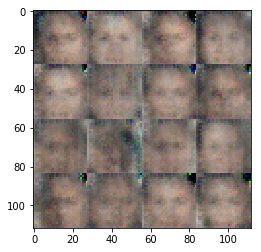

Epoch 1/1... Generator Loss: 5.6222 Discriminator Loss: 0.6756...
Epoch 1/1... Generator Loss: 2.8460 Discriminator Loss: 0.5525...
Epoch 1/1... Generator Loss: 3.4548 Discriminator Loss: 0.4160...
Epoch 1/1... Generator Loss: 4.6588 Discriminator Loss: 0.4268...
Epoch 1/1... Generator Loss: 3.2945 Discriminator Loss: 0.4117...
Epoch 1/1... Generator Loss: 4.5697 Discriminator Loss: 0.3879...
Epoch 1/1... Generator Loss: 4.1133 Discriminator Loss: 0.3650...
Epoch 1/1... Generator Loss: 2.5262 Discriminator Loss: 0.4946...
Epoch 1/1... Generator Loss: 3.4942 Discriminator Loss: 0.3811...
Epoch 1/1... Generator Loss: 4.7819 Discriminator Loss: 0.3918...


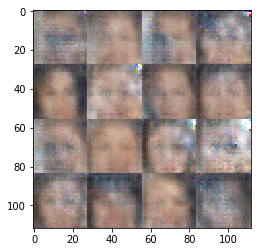

Epoch 1/1... Generator Loss: 5.0631 Discriminator Loss: 0.3526...
Epoch 1/1... Generator Loss: 3.4460 Discriminator Loss: 0.3839...
Epoch 1/1... Generator Loss: 4.3973 Discriminator Loss: 0.3571...
Epoch 1/1... Generator Loss: 4.3206 Discriminator Loss: 0.3722...
Epoch 1/1... Generator Loss: 0.5296 Discriminator Loss: 1.8654...
Epoch 1/1... Generator Loss: 0.4924 Discriminator Loss: 1.9858...
Epoch 1/1... Generator Loss: 1.4821 Discriminator Loss: 0.7726...
Epoch 1/1... Generator Loss: 2.9139 Discriminator Loss: 0.4545...
Epoch 1/1... Generator Loss: 2.4354 Discriminator Loss: 0.4783...
Epoch 1/1... Generator Loss: 3.2822 Discriminator Loss: 0.4016...


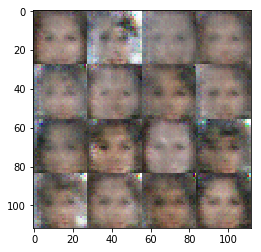

Epoch 1/1... Generator Loss: 2.8926 Discriminator Loss: 0.4393...
Epoch 1/1... Generator Loss: 3.4372 Discriminator Loss: 0.4180...
Epoch 1/1... Generator Loss: 1.9570 Discriminator Loss: 1.1260...
Epoch 1/1... Generator Loss: 1.2787 Discriminator Loss: 1.0856...
Epoch 1/1... Generator Loss: 3.3185 Discriminator Loss: 0.4067...
Epoch 1/1... Generator Loss: 2.6027 Discriminator Loss: 0.4032...
Epoch 1/1... Generator Loss: 3.3315 Discriminator Loss: 0.4154...
Epoch 1/1... Generator Loss: 4.0270 Discriminator Loss: 0.3897...
Epoch 1/1... Generator Loss: 3.3126 Discriminator Loss: 0.4304...
Epoch 1/1... Generator Loss: 1.0267 Discriminator Loss: 1.1418...


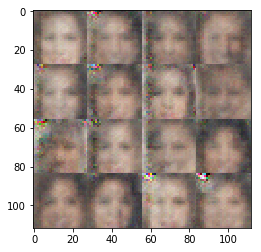

Epoch 1/1... Generator Loss: 2.8151 Discriminator Loss: 0.5544...
Epoch 1/1... Generator Loss: 1.4896 Discriminator Loss: 1.3244...
Epoch 1/1... Generator Loss: 1.6202 Discriminator Loss: 0.8093...
Epoch 1/1... Generator Loss: 2.9828 Discriminator Loss: 0.8420...
Epoch 1/1... Generator Loss: 2.5122 Discriminator Loss: 0.5867...
Epoch 1/1... Generator Loss: 0.9518 Discriminator Loss: 1.2129...
Epoch 1/1... Generator Loss: 1.3723 Discriminator Loss: 0.8670...
Epoch 1/1... Generator Loss: 2.7274 Discriminator Loss: 1.7610...
Epoch 1/1... Generator Loss: 0.5057 Discriminator Loss: 1.3919...
Epoch 1/1... Generator Loss: 1.2719 Discriminator Loss: 1.4454...


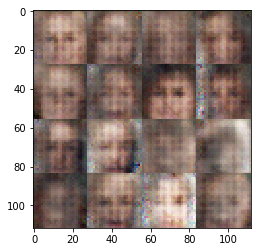

Epoch 1/1... Generator Loss: 5.5865 Discriminator Loss: 0.5961...
Epoch 1/1... Generator Loss: 2.7730 Discriminator Loss: 0.8897...
Epoch 1/1... Generator Loss: 0.5287 Discriminator Loss: 1.3956...
Epoch 1/1... Generator Loss: 0.3873 Discriminator Loss: 1.9043...
Epoch 1/1... Generator Loss: 0.6421 Discriminator Loss: 1.2277...
Epoch 1/1... Generator Loss: 1.0058 Discriminator Loss: 0.9593...
Epoch 1/1... Generator Loss: 1.7386 Discriminator Loss: 0.7300...
Epoch 1/1... Generator Loss: 0.2867 Discriminator Loss: 1.9800...
Epoch 1/1... Generator Loss: 3.7687 Discriminator Loss: 3.4518...
Epoch 1/1... Generator Loss: 0.9435 Discriminator Loss: 1.1619...


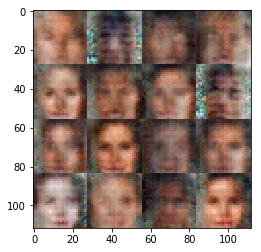

Epoch 1/1... Generator Loss: 2.9343 Discriminator Loss: 1.9193...
Epoch 1/1... Generator Loss: 0.4124 Discriminator Loss: 1.8267...
Epoch 1/1... Generator Loss: 0.8663 Discriminator Loss: 1.2938...
Epoch 1/1... Generator Loss: 1.5824 Discriminator Loss: 1.3184...
Epoch 1/1... Generator Loss: 1.7137 Discriminator Loss: 0.6651...
Epoch 1/1... Generator Loss: 0.9388 Discriminator Loss: 0.9873...
Epoch 1/1... Generator Loss: 3.3636 Discriminator Loss: 2.2429...
Epoch 1/1... Generator Loss: 1.4925 Discriminator Loss: 0.9055...
Epoch 1/1... Generator Loss: 0.6609 Discriminator Loss: 1.0919...
Epoch 1/1... Generator Loss: 0.5924 Discriminator Loss: 1.5006...


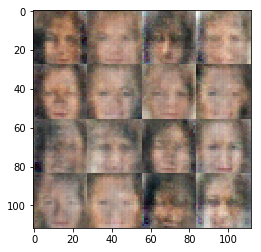

Epoch 1/1... Generator Loss: 3.5227 Discriminator Loss: 1.9065...
Epoch 1/1... Generator Loss: 3.6473 Discriminator Loss: 1.4577...
Epoch 1/1... Generator Loss: 0.7346 Discriminator Loss: 1.2677...
Epoch 1/1... Generator Loss: 2.4238 Discriminator Loss: 0.4935...
Epoch 1/1... Generator Loss: 2.7270 Discriminator Loss: 1.8101...
Epoch 1/1... Generator Loss: 0.9041 Discriminator Loss: 1.0264...
Epoch 1/1... Generator Loss: 5.5338 Discriminator Loss: 0.5263...
Epoch 1/1... Generator Loss: 0.6532 Discriminator Loss: 1.2136...
Epoch 1/1... Generator Loss: 4.0054 Discriminator Loss: 1.5351...
Epoch 1/1... Generator Loss: 3.7498 Discriminator Loss: 0.5774...


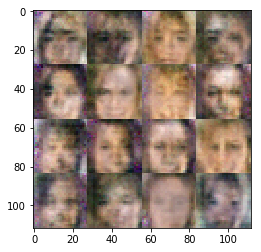

Epoch 1/1... Generator Loss: 1.0382 Discriminator Loss: 0.9666...
Epoch 1/1... Generator Loss: 0.9786 Discriminator Loss: 0.9921...
Epoch 1/1... Generator Loss: 0.9081 Discriminator Loss: 0.9437...
Epoch 1/1... Generator Loss: 1.9261 Discriminator Loss: 1.0338...
Epoch 1/1... Generator Loss: 1.2957 Discriminator Loss: 0.9659...
Epoch 1/1... Generator Loss: 0.8362 Discriminator Loss: 1.0274...
Epoch 1/1... Generator Loss: 0.5282 Discriminator Loss: 1.4350...
Epoch 1/1... Generator Loss: 1.2227 Discriminator Loss: 0.9758...
Epoch 1/1... Generator Loss: 5.1422 Discriminator Loss: 1.0542...
Epoch 1/1... Generator Loss: 0.5946 Discriminator Loss: 1.3550...


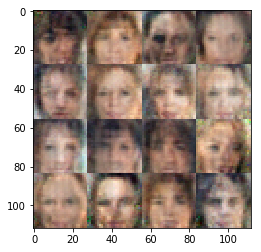

Epoch 1/1... Generator Loss: 2.6416 Discriminator Loss: 0.4556...
Epoch 1/1... Generator Loss: 1.1175 Discriminator Loss: 1.2223...
Epoch 1/1... Generator Loss: 0.4740 Discriminator Loss: 1.5461...
Epoch 1/1... Generator Loss: 0.5516 Discriminator Loss: 1.4144...
Epoch 1/1... Generator Loss: 0.8923 Discriminator Loss: 1.0356...
Epoch 1/1... Generator Loss: 1.2264 Discriminator Loss: 0.8619...
Epoch 1/1... Generator Loss: 0.7320 Discriminator Loss: 1.2315...
Epoch 1/1... Generator Loss: 1.3184 Discriminator Loss: 1.1289...
Epoch 1/1... Generator Loss: 1.1711 Discriminator Loss: 1.0662...
Epoch 1/1... Generator Loss: 0.8870 Discriminator Loss: 1.2811...


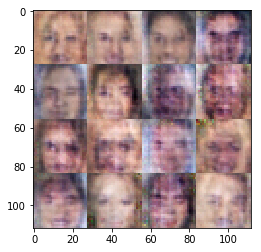

Epoch 1/1... Generator Loss: 0.8711 Discriminator Loss: 1.2098...
Epoch 1/1... Generator Loss: 0.8324 Discriminator Loss: 1.4765...
Epoch 1/1... Generator Loss: 1.0410 Discriminator Loss: 1.3332...
Epoch 1/1... Generator Loss: 0.9868 Discriminator Loss: 1.2872...
Epoch 1/1... Generator Loss: 1.0301 Discriminator Loss: 1.1936...
Epoch 1/1... Generator Loss: 1.2032 Discriminator Loss: 1.1046...
Epoch 1/1... Generator Loss: 1.0854 Discriminator Loss: 1.0641...
Epoch 1/1... Generator Loss: 0.9247 Discriminator Loss: 1.2095...
Epoch 1/1... Generator Loss: 1.4933 Discriminator Loss: 1.2597...
Epoch 1/1... Generator Loss: 0.8010 Discriminator Loss: 1.1684...


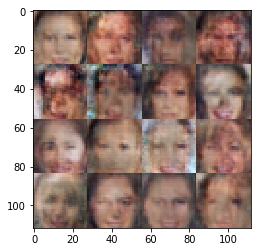

Epoch 1/1... Generator Loss: 0.8910 Discriminator Loss: 1.3989...
Epoch 1/1... Generator Loss: 0.8989 Discriminator Loss: 1.1377...
Epoch 1/1... Generator Loss: 1.0031 Discriminator Loss: 1.1858...
Epoch 1/1... Generator Loss: 0.9240 Discriminator Loss: 1.2870...
Epoch 1/1... Generator Loss: 0.6374 Discriminator Loss: 1.2875...
Epoch 1/1... Generator Loss: 0.1672 Discriminator Loss: 2.5201...
Epoch 1/1... Generator Loss: 0.6870 Discriminator Loss: 1.2741...
Epoch 1/1... Generator Loss: 0.6994 Discriminator Loss: 1.3755...
Epoch 1/1... Generator Loss: 1.0976 Discriminator Loss: 0.8533...
Epoch 1/1... Generator Loss: 1.8384 Discriminator Loss: 1.4503...


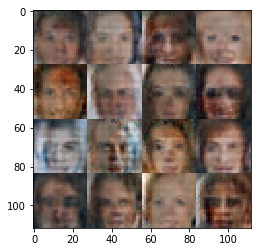

Epoch 1/1... Generator Loss: 0.9494 Discriminator Loss: 1.1838...
Epoch 1/1... Generator Loss: 0.8324 Discriminator Loss: 1.2337...
Epoch 1/1... Generator Loss: 0.8816 Discriminator Loss: 1.1983...
Epoch 1/1... Generator Loss: 1.0929 Discriminator Loss: 1.3438...
Epoch 1/1... Generator Loss: 1.0259 Discriminator Loss: 1.2473...
Epoch 1/1... Generator Loss: 0.7494 Discriminator Loss: 1.2855...
Epoch 1/1... Generator Loss: 0.7694 Discriminator Loss: 1.2612...
Epoch 1/1... Generator Loss: 1.4416 Discriminator Loss: 1.1923...
Epoch 1/1... Generator Loss: 0.6671 Discriminator Loss: 1.3508...
Epoch 1/1... Generator Loss: 0.8743 Discriminator Loss: 1.3290...


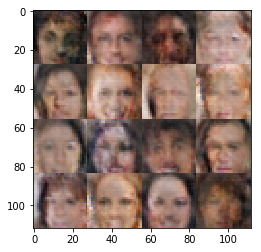

Epoch 1/1... Generator Loss: 1.1027 Discriminator Loss: 1.1518...
Epoch 1/1... Generator Loss: 0.6626 Discriminator Loss: 1.2734...
Epoch 1/1... Generator Loss: 0.4524 Discriminator Loss: 1.5480...
Epoch 1/1... Generator Loss: 1.2041 Discriminator Loss: 1.1122...
Epoch 1/1... Generator Loss: 0.6540 Discriminator Loss: 1.2302...
Epoch 1/1... Generator Loss: 0.6534 Discriminator Loss: 1.2489...
Epoch 1/1... Generator Loss: 1.0816 Discriminator Loss: 0.9414...
Epoch 1/1... Generator Loss: 1.2821 Discriminator Loss: 1.0016...
Epoch 1/1... Generator Loss: 1.4845 Discriminator Loss: 0.9303...
Epoch 1/1... Generator Loss: 1.0880 Discriminator Loss: 1.1533...


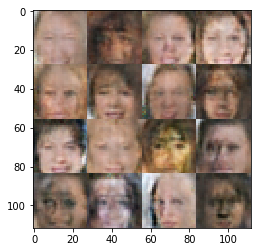

Epoch 1/1... Generator Loss: 1.3430 Discriminator Loss: 1.2360...
Epoch 1/1... Generator Loss: 2.1154 Discriminator Loss: 1.6003...
Epoch 1/1... Generator Loss: 0.8567 Discriminator Loss: 1.2192...
Epoch 1/1... Generator Loss: 1.4536 Discriminator Loss: 1.1055...
Epoch 1/1... Generator Loss: 1.2783 Discriminator Loss: 0.9809...
Epoch 1/1... Generator Loss: 0.3829 Discriminator Loss: 1.7057...
Epoch 1/1... Generator Loss: 0.7707 Discriminator Loss: 1.2322...
Epoch 1/1... Generator Loss: 0.9498 Discriminator Loss: 1.2564...
Epoch 1/1... Generator Loss: 0.7006 Discriminator Loss: 1.2104...
Epoch 1/1... Generator Loss: 0.7181 Discriminator Loss: 1.2473...


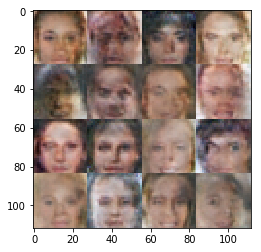

Epoch 1/1... Generator Loss: 1.3112 Discriminator Loss: 1.0875...
Epoch 1/1... Generator Loss: 1.4586 Discriminator Loss: 1.0437...
Epoch 1/1... Generator Loss: 1.0655 Discriminator Loss: 1.3247...
Epoch 1/1... Generator Loss: 0.5399 Discriminator Loss: 1.3932...
Epoch 1/1... Generator Loss: 1.0205 Discriminator Loss: 0.9946...
Epoch 1/1... Generator Loss: 0.7448 Discriminator Loss: 1.2681...
Epoch 1/1... Generator Loss: 0.8718 Discriminator Loss: 1.3623...
Epoch 1/1... Generator Loss: 0.8104 Discriminator Loss: 1.1777...
Epoch 1/1... Generator Loss: 0.9546 Discriminator Loss: 1.1447...
Epoch 1/1... Generator Loss: 1.4059 Discriminator Loss: 1.2065...


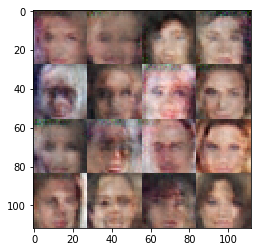

Epoch 1/1... Generator Loss: 0.4938 Discriminator Loss: 1.6797...
Epoch 1/1... Generator Loss: 1.0182 Discriminator Loss: 1.1186...
Epoch 1/1... Generator Loss: 0.8253 Discriminator Loss: 1.0983...
Epoch 1/1... Generator Loss: 0.6184 Discriminator Loss: 1.3866...
Epoch 1/1... Generator Loss: 1.2415 Discriminator Loss: 1.1627...
Epoch 1/1... Generator Loss: 0.8371 Discriminator Loss: 1.2423...
Epoch 1/1... Generator Loss: 0.6787 Discriminator Loss: 1.3009...
Epoch 1/1... Generator Loss: 0.7458 Discriminator Loss: 1.2793...
Epoch 1/1... Generator Loss: 0.4172 Discriminator Loss: 1.5284...
Epoch 1/1... Generator Loss: 1.1372 Discriminator Loss: 1.1015...


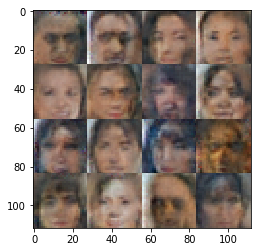

Epoch 1/1... Generator Loss: 1.0876 Discriminator Loss: 0.9902...
Epoch 1/1... Generator Loss: 1.6964 Discriminator Loss: 0.8720...
Epoch 1/1... Generator Loss: 0.7412 Discriminator Loss: 1.2404...
Epoch 1/1... Generator Loss: 0.7670 Discriminator Loss: 1.0710...
Epoch 1/1... Generator Loss: 0.9364 Discriminator Loss: 1.2445...
Epoch 1/1... Generator Loss: 1.0823 Discriminator Loss: 1.2897...
Epoch 1/1... Generator Loss: 0.8809 Discriminator Loss: 1.1642...
Epoch 1/1... Generator Loss: 0.8042 Discriminator Loss: 1.1067...
Epoch 1/1... Generator Loss: 1.3140 Discriminator Loss: 1.0003...
Epoch 1/1... Generator Loss: 0.8245 Discriminator Loss: 1.1830...


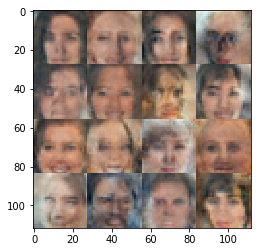

Epoch 1/1... Generator Loss: 0.6784 Discriminator Loss: 1.3261...
Epoch 1/1... Generator Loss: 0.8201 Discriminator Loss: 1.1560...
Epoch 1/1... Generator Loss: 1.0597 Discriminator Loss: 0.8828...
Epoch 1/1... Generator Loss: 1.2220 Discriminator Loss: 1.0012...
Epoch 1/1... Generator Loss: 1.9540 Discriminator Loss: 1.4153...
Epoch 1/1... Generator Loss: 1.5907 Discriminator Loss: 0.8548...
Epoch 1/1... Generator Loss: 0.6880 Discriminator Loss: 1.3004...
Epoch 1/1... Generator Loss: 0.2058 Discriminator Loss: 2.2079...
Epoch 1/1... Generator Loss: 0.7029 Discriminator Loss: 1.3326...
Epoch 1/1... Generator Loss: 1.2015 Discriminator Loss: 1.1242...


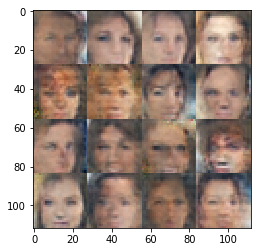

Epoch 1/1... Generator Loss: 0.7645 Discriminator Loss: 1.2881...
Epoch 1/1... Generator Loss: 0.8497 Discriminator Loss: 1.1938...
Epoch 1/1... Generator Loss: 0.5400 Discriminator Loss: 1.3974...
Epoch 1/1... Generator Loss: 0.6862 Discriminator Loss: 1.2592...
Epoch 1/1... Generator Loss: 0.8664 Discriminator Loss: 1.1273...
Epoch 1/1... Generator Loss: 0.6620 Discriminator Loss: 1.3021...
Epoch 1/1... Generator Loss: 0.8856 Discriminator Loss: 1.1297...
Epoch 1/1... Generator Loss: 1.1209 Discriminator Loss: 1.1558...
Epoch 1/1... Generator Loss: 1.2831 Discriminator Loss: 0.9372...
Epoch 1/1... Generator Loss: 2.1629 Discriminator Loss: 1.4852...


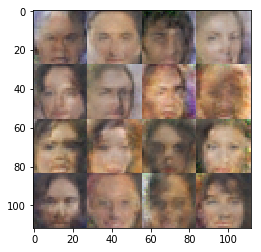

Epoch 1/1... Generator Loss: 0.9003 Discriminator Loss: 1.1045...
Epoch 1/1... Generator Loss: 0.8867 Discriminator Loss: 1.1778...
Epoch 1/1... Generator Loss: 0.7327 Discriminator Loss: 1.2424...
Epoch 1/1... Generator Loss: 0.8376 Discriminator Loss: 1.1674...
Epoch 1/1... Generator Loss: 1.5944 Discriminator Loss: 1.0606...
Epoch 1/1... Generator Loss: 2.8162 Discriminator Loss: 0.8198...
Epoch 1/1... Generator Loss: 0.5305 Discriminator Loss: 1.3924...
Epoch 1/1... Generator Loss: 0.6758 Discriminator Loss: 1.2946...
Epoch 1/1... Generator Loss: 1.1587 Discriminator Loss: 1.0617...
Epoch 1/1... Generator Loss: 0.7453 Discriminator Loss: 1.2684...


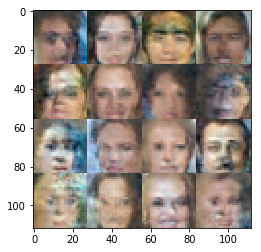

Epoch 1/1... Generator Loss: 0.5867 Discriminator Loss: 1.4069...
Epoch 1/1... Generator Loss: 2.7290 Discriminator Loss: 0.6674...
Epoch 1/1... Generator Loss: 0.9848 Discriminator Loss: 1.2829...
Epoch 1/1... Generator Loss: 0.9533 Discriminator Loss: 1.1692...
Epoch 1/1... Generator Loss: 0.8420 Discriminator Loss: 1.1742...
Epoch 1/1... Generator Loss: 0.5935 Discriminator Loss: 1.4052...
Epoch 1/1... Generator Loss: 1.3103 Discriminator Loss: 1.3167...
Epoch 1/1... Generator Loss: 0.5809 Discriminator Loss: 1.3451...
Epoch 1/1... Generator Loss: 0.4521 Discriminator Loss: 1.4850...
Epoch 1/1... Generator Loss: 1.0001 Discriminator Loss: 1.1157...


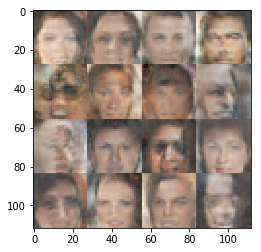

Epoch 1/1... Generator Loss: 1.6268 Discriminator Loss: 1.0487...
Epoch 1/1... Generator Loss: 1.2521 Discriminator Loss: 1.0384...
Epoch 1/1... Generator Loss: 0.5727 Discriminator Loss: 1.4124...
Epoch 1/1... Generator Loss: 0.8508 Discriminator Loss: 1.1610...
Epoch 1/1... Generator Loss: 1.3404 Discriminator Loss: 1.0641...
Epoch 1/1... Generator Loss: 1.6453 Discriminator Loss: 1.2204...
Epoch 1/1... Generator Loss: 0.6770 Discriminator Loss: 1.2213...
Epoch 1/1... Generator Loss: 0.9323 Discriminator Loss: 1.0867...
Epoch 1/1... Generator Loss: 0.7316 Discriminator Loss: 1.2656...
Epoch 1/1... Generator Loss: 0.5482 Discriminator Loss: 1.3205...


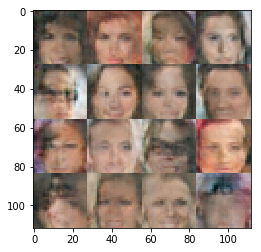

Epoch 1/1... Generator Loss: 0.4883 Discriminator Loss: 1.4260...
Epoch 1/1... Generator Loss: 0.6402 Discriminator Loss: 1.1972...
Epoch 1/1... Generator Loss: 0.5792 Discriminator Loss: 1.2835...
Epoch 1/1... Generator Loss: 2.6748 Discriminator Loss: 1.5330...
Epoch 1/1... Generator Loss: 0.6291 Discriminator Loss: 1.3303...
Epoch 1/1... Generator Loss: 1.2585 Discriminator Loss: 1.1596...
Epoch 1/1... Generator Loss: 0.9094 Discriminator Loss: 1.1092...
Epoch 1/1... Generator Loss: 0.4608 Discriminator Loss: 1.5033...
Epoch 1/1... Generator Loss: 0.6968 Discriminator Loss: 1.2633...
Epoch 1/1... Generator Loss: 0.6351 Discriminator Loss: 1.2688...


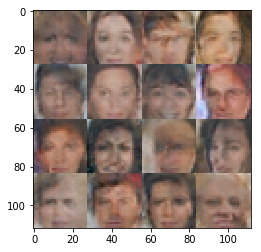

Epoch 1/1... Generator Loss: 1.1101 Discriminator Loss: 1.1440...
Epoch 1/1... Generator Loss: 1.4643 Discriminator Loss: 0.9824...
Epoch 1/1... Generator Loss: 1.0881 Discriminator Loss: 1.3775...
Epoch 1/1... Generator Loss: 0.9092 Discriminator Loss: 1.2770...
Epoch 1/1... Generator Loss: 0.5822 Discriminator Loss: 1.3562...
Epoch 1/1... Generator Loss: 0.5846 Discriminator Loss: 1.3094...
Epoch 1/1... Generator Loss: 0.9604 Discriminator Loss: 1.2265...
Epoch 1/1... Generator Loss: 0.5909 Discriminator Loss: 1.3461...
Epoch 1/1... Generator Loss: 0.5994 Discriminator Loss: 1.3154...
Epoch 1/1... Generator Loss: 0.7270 Discriminator Loss: 1.2295...


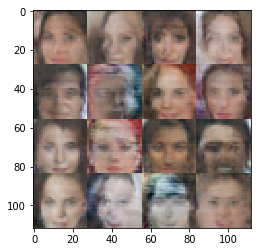

Epoch 1/1... Generator Loss: 0.7341 Discriminator Loss: 1.2395...
Epoch 1/1... Generator Loss: 1.4031 Discriminator Loss: 1.0114...
Epoch 1/1... Generator Loss: 1.1852 Discriminator Loss: 1.1400...
Epoch 1/1... Generator Loss: 0.7110 Discriminator Loss: 1.2331...
Epoch 1/1... Generator Loss: 1.5957 Discriminator Loss: 1.0064...
Epoch 1/1... Generator Loss: 0.8020 Discriminator Loss: 1.2512...
Epoch 1/1... Generator Loss: 1.5259 Discriminator Loss: 0.9826...
Epoch 1/1... Generator Loss: 0.9720 Discriminator Loss: 0.9841...
Epoch 1/1... Generator Loss: 0.9481 Discriminator Loss: 1.1178...
Epoch 1/1... Generator Loss: 0.3087 Discriminator Loss: 1.7409...


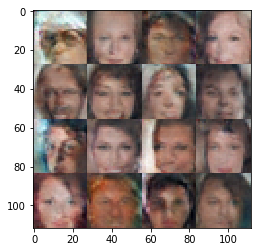

Epoch 1/1... Generator Loss: 0.7657 Discriminator Loss: 1.1981...
Epoch 1/1... Generator Loss: 0.9784 Discriminator Loss: 1.5868...
Epoch 1/1... Generator Loss: 0.8253 Discriminator Loss: 1.1504...
Epoch 1/1... Generator Loss: 0.8587 Discriminator Loss: 1.2386...
Epoch 1/1... Generator Loss: 0.8538 Discriminator Loss: 1.2777...
Epoch 1/1... Generator Loss: 0.8252 Discriminator Loss: 1.1504...
Epoch 1/1... Generator Loss: 1.3284 Discriminator Loss: 1.1434...
Epoch 1/1... Generator Loss: 0.8211 Discriminator Loss: 1.1380...
Epoch 1/1... Generator Loss: 0.8245 Discriminator Loss: 1.1625...
Epoch 1/1... Generator Loss: 0.9676 Discriminator Loss: 1.3735...


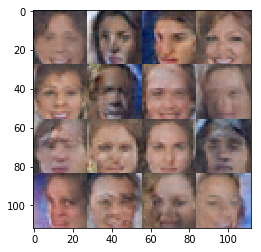

Epoch 1/1... Generator Loss: 0.4984 Discriminator Loss: 1.4214...
Epoch 1/1... Generator Loss: 0.9349 Discriminator Loss: 1.0367...
Epoch 1/1... Generator Loss: 0.5241 Discriminator Loss: 1.3731...
Epoch 1/1... Generator Loss: 0.6755 Discriminator Loss: 1.1677...
Epoch 1/1... Generator Loss: 0.9513 Discriminator Loss: 1.1351...
Epoch 1/1... Generator Loss: 0.5577 Discriminator Loss: 1.4029...
Epoch 1/1... Generator Loss: 1.1219 Discriminator Loss: 1.0852...
Epoch 1/1... Generator Loss: 1.1549 Discriminator Loss: 1.2709...
Epoch 1/1... Generator Loss: 0.7749 Discriminator Loss: 1.1295...
Epoch 1/1... Generator Loss: 1.0131 Discriminator Loss: 1.1757...


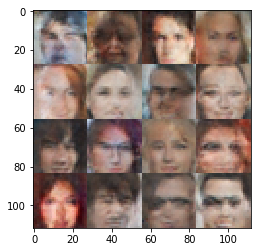

Epoch 1/1... Generator Loss: 1.3092 Discriminator Loss: 1.1314...
Epoch 1/1... Generator Loss: 1.0465 Discriminator Loss: 1.0345...
Epoch 1/1... Generator Loss: 1.0255 Discriminator Loss: 1.2810...
Epoch 1/1... Generator Loss: 1.1898 Discriminator Loss: 1.1041...
Epoch 1/1... Generator Loss: 0.9415 Discriminator Loss: 1.1763...
Epoch 1/1... Generator Loss: 0.8389 Discriminator Loss: 1.1356...


In [26]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.